In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np

In [104]:
# df = pd.read_csv('/Users/newuser/Projects/robust-algo-trader/data/EURUSD/EURUSD_H1_200702210000_202304242100.csv')
df = pd.read_csv('/projects/genomic-ml/da2343/ml_project_2/data/EURUSD/EURUSD_H1_200702210000_202304242100_Update.csv')

# add new Index column
df['Index'] = df.index

In [105]:
# First 30 rows
# df = df.head(24 * 5)

df = df.head(24*5)

green_df = df[df.Close > df.Open].copy()
green_df["Height"] = green_df["Close"] - green_df["Open"]
red_df = df[df.Close < df.Open].copy()
red_df["Height"] = red_df["Open"] - red_df["Close"]

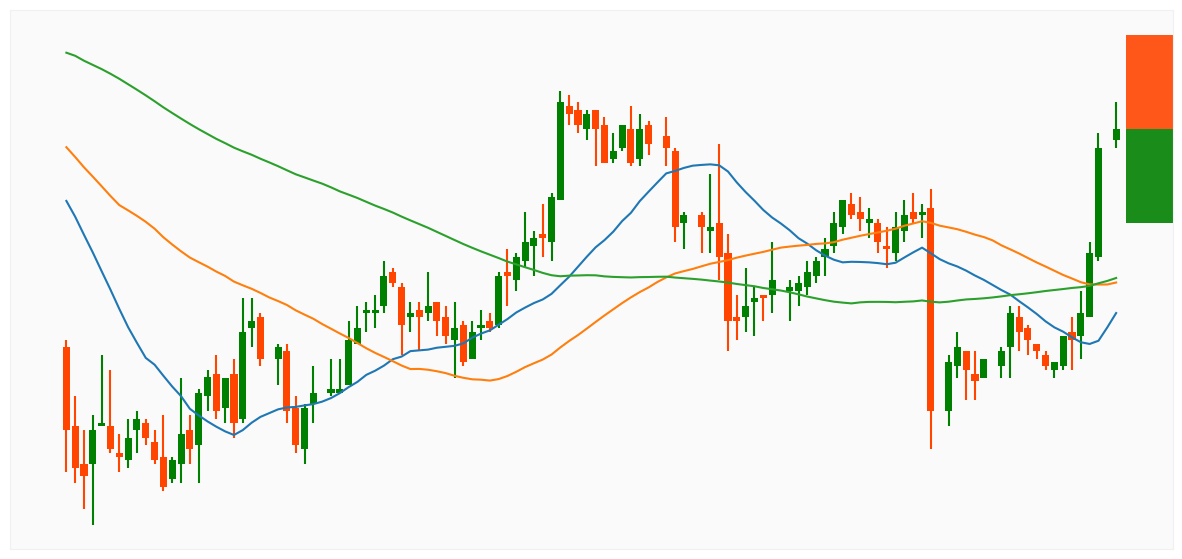

In [106]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,7))

##Grey Lines
plt.vlines(x=green_df["Index"], 
           ymin=green_df["Low"], ymax=green_df["High"],
           color="green")
plt.vlines(x=red_df["Index"], ymin=red_df["Low"], ymax=red_df["High"],
           color="orangered")
##Green Candles
plt.bar(x=green_df["Index"], height=green_df["Height"], bottom=green_df["Open"], color="green")
##Red Candles
plt.bar(x=red_df["Index"], height=red_df["Height"], bottom=red_df["Close"], color="orangered")
plt.plot(df["SMA_20"], label="SMA_20")
# plt.plot(df["SMA_30"], label="SMA_30")
plt.plot(df["SMA_50"], label="SMA_50")
plt.plot(df["SMA_100"], label="SMA_100")

close_price = df["Close"].iloc[-1] # Get the close price of the last row

delta = 0.0025
plt.axhspan(close_price, close_price + delta, facecolor="orangered", xmin= 0.96,  alpha=0.9) 
plt.axhspan(close_price - delta, close_price, facecolor="green", xmin= 0.96,  alpha=0.9) 

        
plt.xticks([])
plt.yticks([])


# plt.savefig('plot.png', dpi=64, bbox_inches='tight')

# Show the plot
plt.show()


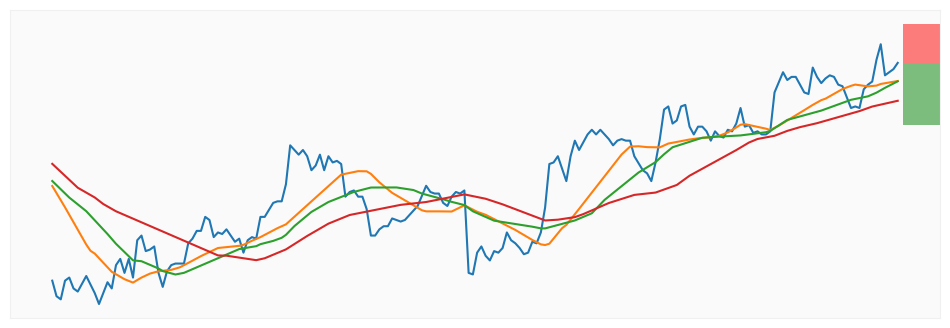

In [45]:
# Plot the price chart with Impulse MACD and its signal line
plt.figure(figsize=(12,4))
# plt.subplot(3, 1, 1) # Create a subplot for the price chart
plt.plot(df["Close"], label="Close")
plt.plot(df["SMA_20"], label="SMA_20")
plt.plot(df["SMA_30"], label="SMA_30")
plt.plot(df["SMA_50"], label="SMA_50")
# plt.plot(df["SMA_100"], label="SMA_100")

close_price = df["Close"].iloc[-1] # Get the close price of the last row

plt.axhspan(close_price, close_price + 0.0025, facecolor="red", xmin= 0.96,  alpha=0.5) 
plt.axhspan(close_price - 0.004, close_price, facecolor="green", xmin= 0.96,  alpha=0.5) 

        
plt.xticks([])
plt.yticks([])

# plt.subplot(3, 1, 2) 
# plt.plot(df["RSI"], label="RSI")
# # plt.axhline(70, color="red", linestyle="--") 
# # plt.axhline(30, color="green", linestyle="--")
# plt.legend()
# plt.title("RSI chart")
# plt.xlabel("")
# plt.ylabel("")
# plt.xticks([])
# plt.yticks([])

# # Plot the ADX graph at the bottom of the plot
# plt.subplot(3, 1, 3)
# plt.plot(df["ADX"], label="ADX")
# plt.legend()
# plt.title("ADX chart")
# plt.xlabel("")
# plt.ylabel("")
# plt.xticks([])
# plt.yticks([])


# plt.savefig('plot.png', dpi=64, bbox_inches='tight')

# Show the plot
plt.show()